In [4]:
import tensorflow as tf

BATCH_SIZE = 16
SEED = 1

# Training set
train_generator = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/new-ecg-images/train',
    batch_size=BATCH_SIZE,
    image_size=(512, 1024),
    color_mode='rgb',
    shuffle=True,
    validation_split=0.2,
    label_mode='categorical',
    subset='training',
    seed=SEED
)

# Validation set
val_generator = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/new-ecg-images/train',
    batch_size=BATCH_SIZE,
    image_size=(512, 1024),
    color_mode='rgb',
    shuffle=True,
    validation_split=0.2,
    label_mode='categorical',
    subset='validation',
    seed=SEED
)

Found 741 files belonging to 4 classes.
Using 593 files for training.
Found 741 files belonging to 4 classes.
Using 148 files for validation.


In [5]:
from tensorflow.keras.applications import ResNet50

input_shape = (512,1024,3)

base_model = ResNet50(weights='imagenet', 
                      include_top=False,
                      input_shape=input_shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
for layer in base_model.layers: # freezes all the layers in the base model
  layer.trainable = False

# base_model.summary()

In [7]:
iterator = iter(train_generator)

In [8]:
import numpy as np

next(iterator)[0][0].numpy().shape

(512, 1024, 3)

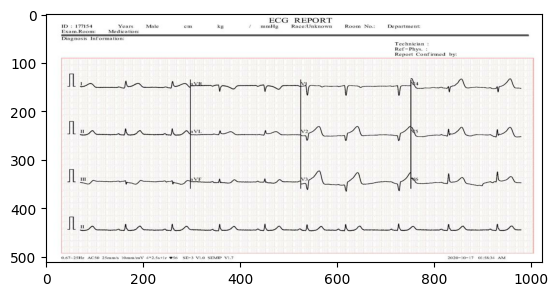

In [9]:
import matplotlib.pyplot as plt # library that allows us to visualize the data


plt.imshow(next(iterator)[0][0].numpy().astype(np.int32)) # shows each image

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

def create_model():
    return Sequential([
        Input(batch_size = 16, shape=input_shape),
        base_model,  # Pre-trained base model
        GlobalAveragePooling2D(),  # Global average pooling layer
        Dense(1024, activation='relu'),  # Custom dense layer for learning
        Dropout(0.2),  # Dropout for regularization
        Dense(512, activation='relu'),  # Another custom dense layer
        Dropout(0.2),  # Another dropout layer
        Dense(4, activation='softmax')  # multiclass classfication
    ])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# stops the training early if there is no improvement
early_stopping = EarlyStopping(
    patience = 5,
    monitor = 'val_loss',
    restore_best_weights = True,
    verbose = 1
)

In [12]:
from tensorflow.keras.metrics import *

metrics = ['accuracy', Precision(), Recall(), AUC(),'f1_score']

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model = create_model()
model.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(learning_rate=0.0001),
                metrics=metrics)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (16, 16, 32, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (16, 2048)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 1024)             │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (16, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 512)              │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (16, 512)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (16, 4)                │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,212,740 (99.99 MB)

 Trainable params: 2,625,028 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
# trains the neural network
history = model.fit(train_generator,
            epochs = 100,
            validation_data = val_generator,
            callbacks = [early_stopping])

Epoch 1/100


I0000 00:00:1742253938.430495     103 service.cc:145] XLA service 0x7f75b0014c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742253938.430569     103 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/38 ━━━━━━━━━━━━━━━━━━━━ 11:59 19s/step - accuracy: 0.3125 - auc: 0.5885 - f1_score: 0.1471 - loss: 1.4523 - precision: 0.6000 - recall: 0.1875

I0000 00:00:1742253950.691896     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 555ms/step - accuracy: 0.3563 - auc: 0.6343 - f1_score: 0.3234 - loss: 1.4093 - precision: 0.4138 - recall: 0.1870 - val_accuracy: 0.6554 - val_auc: 0.8733 - val_f1_score: 0.5412 - val_loss: 0.9668 - val_precision: 0.8298 - val_recall: 0.2635
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.5204 - auc: 0.7945 - f1_score: 0.4775 - loss: 1.0724 - precision: 0.6398 - recall: 0.3249 - val_accuracy: 0.8176 - val_auc: 0.9321 - val_f1_score: 0.8002 - val_loss: 0.8177 - val_precision: 0.9143 - val_recall: 0.4324
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.6076 - auc: 0.8525 - f1_score: 0.5799 - loss: 0.9393 - precision: 0.6856 - recall: 0.3522 - val_accuracy: 0.7635 - val_auc: 0.9259 - val_f1_score: 0.7031 - val_loss: 0.7310 - val_precision: 0.8558 - val_recall: 0.6014
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.6963 - auc: 0.9010 - f1_score: 0.6630 - loss: 0.7855 - precision: 0.7814 - recall: 0.5327

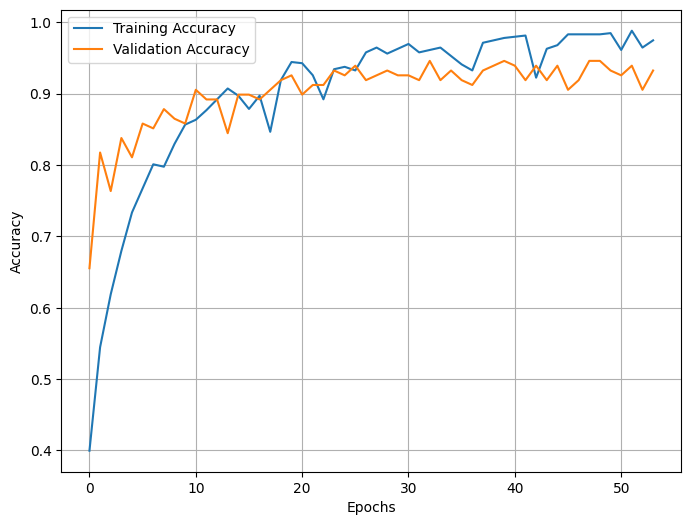

In [14]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with your model's history object
plot_accuracy(history)

In [15]:
import pickle

# Save history to a file
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

# save model
model.save('ecg_classifier_model.h5')
!zip -r ecg_classifier_model.zip ecg_classifier_model.h5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: ecg_classifier_model.h5 (deflated 12%)


In [16]:
import numpy as np

test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/new-ecg-images/test',
    image_size=(512, 1024),
    label_mode = 'categorical')

test_dataset = test_dataset.unbatch()

# Look at first few batches
ecg_test_images = []
test_labels = []
for images, labels in test_dataset:
    ecg_test_images.append(images)
    test_labels.append(labels)  # Convert tensor to numpy array

images_list = np.array(ecg_test_images)
labels_list = np.array(test_labels)

Found 187 files belonging to 4 classes.


In [17]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1 = model.evaluate(images_list, labels_list)
print(f'Accuracy is {test_accuracy:.2%}.')
print(f'Precision is {test_precision:.2%}.')
print(test_recall)
print(f"{2*test_precision*test_recall/(test_precision+test_recall):.2%}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9651 - auc: 0.9910 - f1_score: 0.9593 - loss: 0.2356 - precision: 0.9651 - recall: 0.9651 
Accuracy is 95.19%.
Precision is 95.19%.
0.9518716335296631
95.19%


In [18]:
print(test_loss)
print(test_auc)

0.22718951106071472
0.9915686845779419


In [19]:
predictions = model.predict(images_list)
predicted_classes = np.argmax(predictions, axis=1)
# predicted_classes = to_categorical(predicted_classes)

print(predicted_classes[0])

class_map = {
    0: 'Myocardial Infarction (MI)',
    1: 'History of MI',
    2: 'Abnormal Heartbeat',
    3: 'Normal Heartbeat'
}

labeled_predictions = [class_map[pred] for pred in predicted_classes]

print(f'Prediction: {labeled_predictions[0]}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 874ms/step
3
Prediction: Normal Heartbeat


In [20]:
from sklearn.metrics import *
from tensorflow.keras.utils import to_categorical

y_true = labels_list
y_pred = to_categorical(predicted_classes)
target_names = ["MI", "History of MI", "Abnormal", "Normal"]

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

               precision    recall  f1-score   support

           MI     0.9796    1.0000    0.9897        48
History of MI     0.9091    0.8571    0.8824        35
     Abnormal     0.9556    0.9149    0.9348        47
       Normal     0.9500    1.0000    0.9744        57

    micro avg     0.9519    0.9519    0.9519       187
    macro avg     0.9486    0.9430    0.9453       187
 weighted avg     0.9513    0.9519    0.9511       187
  samples avg     0.9519    0.9519    0.9519       187



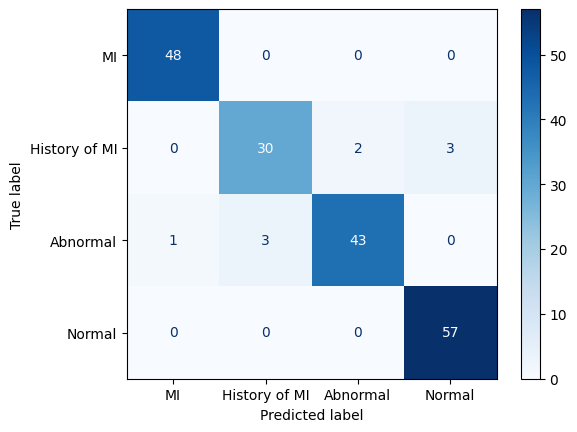

In [21]:
# Convert one-hot encoded labels to class indices
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()